In [6]:
import sys
from pathlib import Path

In [7]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [8]:
import os

In [9]:
import numpy as np
from functools import partial
from tqdm.autonotebook import tqdm

/tmp/ipykernel_4168/1966244604.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [10]:
from chequeparser.wrappers.detection_results import DetectionResults
from chequeparser.wrappers.bbox import BBox
from chequeparser.utilities.ds_utils import concat_ds

In [11]:
from chequeparser.datasets.fileds import FileDS
from chequeparser.datasets.imageds import ImageDS
from chequeparser.datasets.base import BaseDS

In [12]:
from chequeparser.models.arch import UL_RTDETR, DOCTR_RECOG_PRETRAINED, DOCTR_DETECT_PRETRAINED
from chequeparser.models.detection.ultralytics import UltralyticsDetect
from chequeparser.models.detection.doctr import DoctrDetect
from chequeparser.models.recognition.doctr import DoctrRecognize
from chequeparser.core.detector import detect
from chequeparser.core.recognizer import recognize
from chequeparser.utilities.io_utils import save_dets, load_dets

In [13]:
import pkg_resources
from symspellpy import SymSpell

## config

In [244]:
dir_images = "../data/public/train/images/"
dir_sav = "temp/"
f_roi_dets_sav = os.path.join(dir_sav, "roi_dets.h5")
f_words_dets_sav = os.path.join(dir_sav, "words_dets.h5")
f_true_anchor_dets_sav = os.path.join(dir_sav, "true_anchor_dets.h5")
f_bkp_anchor_dets_sav = os.path.join(dir_sav, "bkp_anchor_dets.h5")
f_bkp2_anchor_dets_sav = os.path.join(dir_sav, "bkp2_anchor_dets.h5")

## load ds

In [15]:
all_ds = FileDS(dir_images)

  0%|          | 0/370 [00:00<?, ?it/s]

2024-02-19 18:39:34.442 | INFO     | chequeparser.utilities.io_utils:get_image_files:34 - Found 369 image files.


In [16]:
rand_id = 57

In [17]:
single_ds = all_ds.get_as_ds(rand_id)

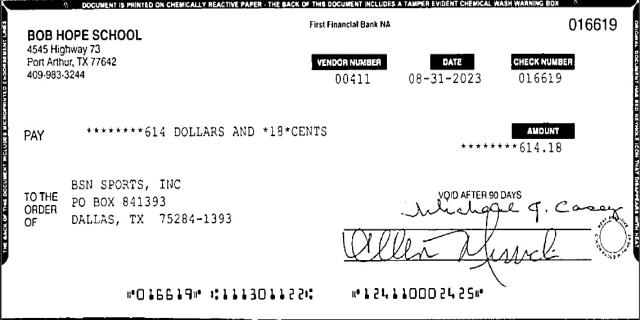

In [92]:
single_ds[0]

## load models

In [12]:
roi_model = UltralyticsDetect("../pretrained/best.pt", arch=UL_RTDETR)

In [13]:
doctr_det_arch_config = {
    "preserve_aspect_ratio": True,
    "symmetric_pad": True
}
words_model = DoctrDetect(path="db_resnet50", 
                          arch=DOCTR_DETECT_PRETRAINED, 
                          arch_config = doctr_det_arch_config)

In [18]:
rec_model = DoctrRecognize(path="crnn_vgg16_bn", arch=DOCTR_RECOG_PRETRAINED)

In [19]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
spell_checker = partial(sym_spell.lookup_compound,
                        max_edit_distance=2, 
                        transfer_casing=True,
                        split_by_space=True,
                        ignore_non_words=True,
                        ignore_term_with_digits=True
                       )
op_spell_check = lambda x: spell_checker(x)[0].term

## run and save model outputs

In [23]:
l_roi_dets = []
for res in tqdm(detect(roi_model, all_ds, stream=True,
                       verbose=False),
              total=len(all_ds)):
    l_roi_dets.append(res)

2024-02-19 17:12:08.283 | INFO     | chequeparser.core.detector:detect:34 - Stream mode: True
2024-02-19 17:12:08.284 | INFO     | chequeparser.core.detector:detect:35 - Batched mode: False
2024-02-19 17:12:08.284 | INFO     | chequeparser.core.detector:detect:36 - Running predict on 369 samples


  0%|          | 0/369 [00:00<?, ?it/s]

In [27]:
save_dets(l_roi_dets, f_roi_dets_sav)

2024-02-19 17:14:49.030 | INFO     | chequeparser.utilities.io_utils:save_dets:69 - Detections saved to temp/roi_dets.h5


In [29]:
l_words_dets = []
for res in tqdm(detect(words_model, all_ds, stream=True),
              total=len(all_ds)):
    l_words_dets.append(res)

2024-02-19 17:15:28.695 | INFO     | chequeparser.core.detector:detect:34 - Stream mode: True
2024-02-19 17:15:28.696 | INFO     | chequeparser.core.detector:detect:35 - Batched mode: False
2024-02-19 17:15:28.696 | INFO     | chequeparser.core.detector:detect:36 - Running predict on 369 samples


  0%|          | 0/369 [00:00<?, ?it/s]

In [28]:
for words_dets in tqdm(l_words_dets):
    temp_ds = words_dets.create_ds(all_ds)
    temp_ds.batched = True
    l_recs = recognize(rec_model, temp_ds, stream=False)
    _ = [box.set_text_and_confidence(rec_results)
     for box, rec_results in zip(words_dets.bboxes, l_recs)]

  0%|          | 0/369 [00:00<?, ?it/s]

2024-02-19 18:48:33.106 | INFO     | chequeparser.core.recognizer:recognize:30 - Stream mode: False
2024-02-19 18:48:33.106 | INFO     | chequeparser.core.recognizer:recognize:31 - Batched mode: True
2024-02-19 18:48:33.107 | INFO     | chequeparser.core.recognizer:recognize:32 - Running predict on 73 samples
2024-02-19 18:48:34.033 | INFO     | chequeparser.core.recognizer:recognize:30 - Stream mode: False
2024-02-19 18:48:34.034 | INFO     | chequeparser.core.recognizer:recognize:31 - Batched mode: True
2024-02-19 18:48:34.035 | INFO     | chequeparser.core.recognizer:recognize:32 - Running predict on 55 samples
2024-02-19 18:48:34.724 | INFO     | chequeparser.core.recognizer:recognize:30 - Stream mode: False
2024-02-19 18:48:34.725 | INFO     | chequeparser.core.recognizer:recognize:31 - Batched mode: True
2024-02-19 18:48:34.726 | INFO     | chequeparser.core.recognizer:recognize:32 - Running predict on 61 samples
2024-02-19 18:48:35.494 | INFO     | chequeparser.core.recognizer:r

In [81]:
save_dets(l_words_dets, f_words_dets_sav)

Reloading 'chequeparser.utilities.io_utils'.
Reloading 'chequeparser.wrappers.bbox'.


2024-02-19 19:18:12.387 | INFO     | chequeparser.utilities.io_utils:save_dets:69 - Detections saved to temp/words_dets.h5


## load dets

In [127]:
l_roi_dets = load_dets(f_roi_dets_sav)

In [128]:
l_words_dets = load_dets(f_words_dets_sav)

In [129]:
len(l_words_dets), len(l_roi_dets)

(369, 369)

## extract features

### anchor features

In [211]:
l_anchor_roi_dets = [roi_dets.filter_by_labels(["orderof"], split=True)[0]
                     for roi_dets in l_roi_dets]

In [224]:
l_left_half_anchor_rois = [anchor_roi_dets.filter_by_region(0, 0.1, 0.35, 0.9)
                           for anchor_roi_dets in l_anchor_roi_dets]
l_left_half_words_dets = [words_dets.filter_by_region(0, 0.1, 0.35, 0.9)
                           for words_dets in l_words_dets]

In [225]:
l_words_inside_rois = [[
                        l_h_w_dets.filter_by_bbox(bbox, thresh=0.7)
                        for bbox in l_h_a_rois.bboxes]
                       for l_h_w_dets, l_h_a_rois in zip(l_left_half_words_dets,
                                                         l_left_half_anchor_rois)
                      ]

In [226]:
l_anchor_scores = [[sum([1 if keyword in bbox.text.lower() else 0 
                      for keyword in ["pay", "to", "the", "order", "of"]
                      for bbox in dets.bboxes])
                 for dets in words_inside_rois]
                for words_inside_rois in l_words_inside_rois]

In [227]:
l_selected_anchor_ids = [max(range(len(anchor_scores)), 
                             key=lambda x : anchor_scores[x])
                         if len(anchor_scores) > 0 else None
                         for anchor_scores in l_anchor_scores]


In [228]:
l_selected_anchor_rois = [rois.filter_by_idxs([idx])
                          if idx is not None else rois.empty()
                          for idx, rois in zip(l_selected_anchor_ids, 
                                               l_left_half_anchor_rois)]


In [229]:
l_spell_corr_left_half_words_dets = [
    left_half_words_dets.empty() for left_half_words_dets
    in l_left_half_words_dets]

In [230]:
for lh_dets, spell_dets in zip(l_left_half_words_dets,
                               l_spell_corr_left_half_words_dets):
    spell_dets.bboxes = [
        box.apply_text_op(op_spell_check, lowercase=True)
        for box in lh_dets.bboxes
    ]

In [241]:
l_bkp_anchor_dets = [
    dets.filter_by_bbox_text("order").filter_by_idxs([0])
    for dets in l_spell_corr_left_half_words_dets]

Reloading 'chequeparser.wrappers.detection_results'.
Reloading 'chequeparser.utilities.io_utils'.


In [242]:
l_bkp2_anchor_dets = [
    dets.filter_by_bbox_text("pay").filter_by_idxs([0])
    for dets in l_spell_corr_left_half_words_dets]

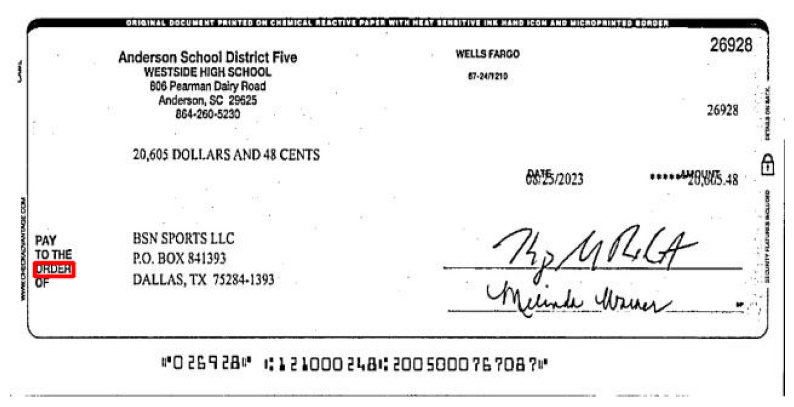

In [243]:
l_bkp_anchor_dets[1].draw(all_ds)

In [247]:
save_dets(l_selected_anchor_rois, f_true_anchor_dets_sav)

2024-02-19 21:15:00.753 | INFO     | chequeparser.utilities.io_utils:save_dets:69 - Detections saved to temp/true_anchor_dets.h5


In [248]:
save_dets(l_bkp_anchor_dets, f_bkp_anchor_dets_sav)
save_dets(l_bkp2_anchor_dets, f_bkp2_anchor_dets_sav)

2024-02-19 21:15:20.147 | INFO     | chequeparser.utilities.io_utils:save_dets:69 - Detections saved to temp/bkp_anchor_dets.h5
2024-02-19 21:15:20.228 | INFO     | chequeparser.utilities.io_utils:save_dets:69 - Detections saved to temp/bkp2_anchor_dets.h5


## payee features